# Modeling: Predicting Daily Searches

This notebook builds and evaluates models to predict `estimated_daily_searches` using weather and temporal features.

**Models**: Linear Regression (baseline) and CatBoost (with SHAP for interpretability)

**Focus**: Performance (target R² ≈ 0.45) with interpretability through SHAP


In [145]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor
import shap
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)


In [146]:
# Load UberEats data
url = "https://raw.githubusercontent.com/cedricly-git/BADS_Capstone_repo/main/Data/ubereats+time_related_vars.csv"
uber = pd.read_csv(url)
uber['Day'] = pd.to_datetime(uber['Day'])

print("UberEats Data Shape:", uber.shape)

# Load weather data for top 10 most populated cities in Switzerland
cities = {
    "Zurich": {"lat": 47.3769, "lon": 8.5417, "pop": 436551},
    "Geneva": {"lat": 46.2044, "lon": 6.1432, "pop": 209061},
    "Basel": {"lat": 47.5596, "lon": 7.5886, "pop": 177571},
    "Lausanne": {"lat": 46.5197, "lon": 6.6323, "pop": 144873},
    "Bern": {"lat": 46.9481, "lon": 7.4474, "pop": 137995},
    "Winterthur": {"lat": 47.5056, "lon": 8.7247, "pop": 120376},
    "Lucerne": {"lat": 47.0502, "lon": 8.3064, "pop": 86234},
    "St. Gallen": {"lat": 47.4245, "lon": 9.3767, "pop": 78863},
    "Lugano": {"lat": 46.0101, "lon": 8.9600, "pop": 63629},
    "Biel": {"lat": 47.1404, "lon": 7.2471, "pop": 56896}
}

# Calculate population weights
total_pop = sum(city["pop"] for city in cities.values())
city_weights = {name: city["pop"] / total_pop for name, city in cities.items()}

start_date = "2023-11-13"
end_date = "2025-11-11"

weather_data = []
print(f"\nFetching weather data for {len(cities)} cities...")
for city, coords in cities.items():
    url1 = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={coords['lat']}&longitude={coords['lon']}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=Europe/Zurich"
    )
    data = requests.get(url1).json()
    for i, date in enumerate(data['daily']['time']):
        weather_data.append({
            "Day": datetime.strptime(date, "%Y-%m-%d"),
            "City": city,
            "Temp_Max": data['daily']['temperature_2m_max'][i],
            "Temp_Min": data['daily']['temperature_2m_min'][i],
            "Precipitation": data['daily']['precipitation_sum'][i]
        })
    print(f"  ✓ {city}")

weather_df = pd.DataFrame(weather_data)

# Calculate population-weighted average weather
weather_df['pop_weight'] = weather_df['City'].map(city_weights)
weather_avg = weather_df.groupby('Day').apply(
    lambda x: pd.Series({
        'Temp_Max': (x['Temp_Max'] * x['pop_weight']).sum(),
        'Temp_Min': (x['Temp_Min'] * x['pop_weight']).sum(),
        'Precipitation': (x['Precipitation'] * x['pop_weight']).sum()
    })
).reset_index()

# Merge datasets
df = pd.merge(uber, weather_avg, on='Day', how='left')

# Add derived features
df["temp_range"] = df["Temp_Max"] - df["Temp_Min"]
df["dayofweek"] = df["Day"].dt.weekday
df["month_num"] = df["Day"].dt.month
df["year"] = df["Day"].dt.year

# Drop columns that shouldn't be used as features (they were used to create estimated_daily_searches)
columns_to_drop = ['weight', 'trend_value', 'total_uber', 'total_ubereats']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"Dropped column: {col}")

print(f"\nMerged Dataset Shape: {df.shape}")
print(f"Date range: {df['Day'].min().date()} to {df['Day'].max().date()}")
print(f"Missing values: {df.isnull().sum().sum()}")


UberEats Data Shape: (728, 10)

Fetching weather data for 10 cities...
  ✓ Zurich
  ✓ Geneva
  ✓ Basel
  ✓ Lausanne
  ✓ Bern
  ✓ Winterthur
  ✓ Lucerne
  ✓ St. Gallen
  ✓ Lugano
  ✓ Biel
Dropped column: weight
Dropped column: trend_value
Dropped column: total_ubereats

Merged Dataset Shape: (728, 14)
Date range: 2023-11-13 to 2025-11-11
Missing values: 0


## 2. Advanced Feature Engineering


In [147]:
# Cyclical encoding for temporal features (better than linear encoding)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

# Weather-derived features
df['temp_comfort'] = (df['Temp_Max'] + df['Temp_Min']) / 2  # Average temperature
df['precip_binary'] = (df['Precipitation'] > 0).astype(int)  # Rain/no rain
df['precip_heavy'] = (df['Precipitation'] > 10).astype(int)  # Heavy rain flag

# Lag features (previous day weather - may affect today's searches)
df['Temp_Max_lag1'] = df['Temp_Max'].shift(1)
df['Temp_Min_lag1'] = df['Temp_Min'].shift(1)
df['Precipitation_lag1'] = df['Precipitation'].shift(1)
df['estimated_daily_searches_lag1'] = df['estimated_daily_searches'].shift(1)

# Extended lag features (lag7 for weekly patterns - lag14 removed to preserve more data)
df['estimated_daily_searches_lag7'] = df['estimated_daily_searches'].shift(7)
df['Temp_Max_lag7'] = df['Temp_Max'].shift(7)
df['Temp_Min_lag7'] = df['Temp_Min'].shift(7)
df['Precipitation_lag7'] = df['Precipitation'].shift(7)

# Rolling averages (smooth out daily fluctuations)
df['Temp_Max_7d'] = df['Temp_Max'].rolling(window=7, center=True).mean()
df['Precipitation_7d'] = df['Precipitation'].rolling(window=7, center=True).mean()

# Polynomial features (capture non-linear temperature effects)
df['Temp_Max_squared'] = df['Temp_Max'] ** 2  # Optimal temperature range effect

# Interaction features (weather × temporal interactions)
# These capture how weather effects differ on weekends/holidays
df['Temp_Max_weekend'] = df['Temp_Max'] * df['is_weekend']
df['Precipitation_weekend'] = df['Precipitation'] * df['is_weekend']
df['temp_comfort_weekend'] = df['temp_comfort'] * df['is_weekend']

# Drop rows with NaN from lag/rolling features
df = df.dropna()

print(f"Dataset shape after feature engineering: {df.shape}")
print(f"\nNew features created:")
print("- Cyclical encoding: dayofweek_sin/cos, month_sin/cos")
print("- Weather derived: temp_comfort, precip_binary, precip_heavy")
print("- Lag features (lag1): Temp_Max_lag1, Temp_Min_lag1, Precipitation_lag1, estimated_daily_searches_lag1")
print("- Extended lag features (lag7): estimated_daily_searches, Temp_Max, Temp_Min, Precipitation")
print("- Rolling averages: Temp_Max_7d, Precipitation_7d")
print("- Polynomial features: Temp_Max_squared")
print("- Interaction features: Temp_Max_weekend, Precipitation_weekend, temp_comfort_weekend")


Dataset shape after feature engineering: (718, 35)

New features created:
- Cyclical encoding: dayofweek_sin/cos, month_sin/cos
- Weather derived: temp_comfort, precip_binary, precip_heavy
- Lag features (lag1): Temp_Max_lag1, Temp_Min_lag1, Precipitation_lag1, estimated_daily_searches_lag1
- Extended lag features (lag7): estimated_daily_searches, Temp_Max, Temp_Min, Precipitation
- Rolling averages: Temp_Max_7d, Precipitation_7d
- Polynomial features: Temp_Max_squared
- Interaction features: Temp_Max_weekend, Precipitation_weekend, temp_comfort_weekend


## 3. Train-Test Split (Time-Series Aware)


In [148]:
# Sort by date to ensure proper time-series split
df = df.sort_values('Day').reset_index(drop=True)

# Time-based split (last 20% for testing)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Training set: {len(train_df)} days ({train_df['Day'].min().date()} to {train_df['Day'].max().date()})")
print(f"Test set: {len(test_df)} days ({test_df['Day'].min().date()} to {test_df['Day'].max().date()})")

# Define target and features
target = 'estimated_daily_searches'

# Feature selection - interpretable features for linear models
feature_candidates = [
    # Temporal
    'is_weekend', 'is_holiday', 'dayofweek_sin', 'dayofweek_cos', 
    'month_sin', 'month_cos',
    # Weather
    'Temp_Max', 'Temp_Min', 'Precipitation', 'temp_range', 'temp_comfort',
    'precip_binary', 'precip_heavy',
    # Lag features (lag1)
    'Temp_Max_lag1', 'Temp_Min_lag1', 'Precipitation_lag1', 'estimated_daily_searches_lag1',
    # Extended lag features (lag7)
    'estimated_daily_searches_lag7',
    'Temp_Max_lag7', 'Temp_Min_lag7', 'Precipitation_lag7',
    # Rolling averages
    'Temp_Max_7d', 'Precipitation_7d',
    # Polynomial features
    'Temp_Max_squared',
    # Interaction features
    'Temp_Max_weekend', 'Precipitation_weekend', 'temp_comfort_weekend'
]

# Check which features exist
available_features = [f for f in feature_candidates if f in df.columns]
print(f"\nAvailable features: {len(available_features)}")
print(available_features)

X_train = train_df[available_features]
y_train = train_df[target]
X_test = test_df[available_features]
y_test = test_df[target]

print(f"\nFeature matrix shape - Train: {X_train.shape}, Test: {X_test.shape}")

# Optional: Feature scaling (helps with regularization, but makes coefficients less interpretable)
# For interpretability, we'll skip scaling, but models with regularization can benefit
# Uncomment below if you want to use scaling:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
# X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


Training set: 574 days (2023-11-20 to 2025-06-17)
Test set: 144 days (2025-06-18 to 2025-11-08)

Available features: 27
['is_weekend', 'is_holiday', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'Temp_Max', 'Temp_Min', 'Precipitation', 'temp_range', 'temp_comfort', 'precip_binary', 'precip_heavy', 'Temp_Max_lag1', 'Temp_Min_lag1', 'Precipitation_lag1', 'estimated_daily_searches_lag1', 'estimated_daily_searches_lag7', 'Temp_Max_lag7', 'Temp_Min_lag7', 'Precipitation_lag7', 'Temp_Max_7d', 'Precipitation_7d', 'Temp_Max_squared', 'Temp_Max_weekend', 'Precipitation_weekend', 'temp_comfort_weekend']

Feature matrix shape - Train: (574, 27), Test: (144, 27)


## 4. Baseline Models


In [149]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display multiple evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print("=" * 50)
    print(f"RMSE:  {rmse:.2f}")
    print(f"MAE:   {mae:.2f}")
    print(f"MAPE:  {mape:.2f}%")
    print(f"R²:    {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2}

# Baseline 1: Simple mean
baseline_mean = y_train.mean()
y_pred_baseline = np.full(len(y_test), baseline_mean)
results = {}
results['Baseline (Mean)'] = evaluate_model(y_test, y_pred_baseline, "Baseline - Mean")

# Baseline 2: Median
baseline_median = y_train.median()
y_pred_median = np.full(len(y_test), baseline_median)
results['Baseline (Median)'] = evaluate_model(y_test, y_pred_median, "Baseline - Median")



Baseline - Mean Performance:
RMSE:  873.92
MAE:   673.16
MAPE:  24.31%
R²:    -0.0346

Baseline - Median Performance:
RMSE:  914.51
MAE:   689.37
MAPE:  23.55%
R²:    -0.1330


## 5. Linear Models


In [150]:
# Store predictions for visualization
predictions = {}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
predictions['Linear Regression'] = y_pred_lr
results['Linear Regression'] = evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Display coefficients
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Features by Absolute Coefficient:")
print(coef_df.head(10))



Linear Regression Performance:
RMSE:  691.85
MAE:   532.14
MAPE:  19.99%
R²:    0.3516

Top 10 Features by Absolute Coefficient:
                 feature  coefficient
0             is_weekend   446.077226
1             is_holiday   396.979603
3          dayofweek_cos  -270.830174
4              month_sin  -268.664755
5              month_cos  -217.396109
2          dayofweek_sin    53.557473
22      Precipitation_7d   -26.733747
21           Temp_Max_7d   -25.498288
11         precip_binary    17.167312
26  temp_comfort_weekend    15.702816


In [151]:
# Ridge Regression (L2 regularization)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
predictions['Ridge Regression'] = y_pred_ridge
results['Ridge Regression'] = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

# Lasso Regression with Hyperparameter Tuning (L1 regularization - feature selection)
# Use time-series cross-validation for tuning
print("\n" + "=" * 60)
print("Hyperparameter Tuning for Lasso Regression")
print("=" * 60)

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Use TimeSeriesSplit for cross-validation (respects temporal order)
tscv = TimeSeriesSplit(n_splits=3)
lasso_grid = GridSearchCV(
    Lasso(max_iter=2000, random_state=42),
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

lasso_grid.fit(X_train, y_train)
print(f"\nBest alpha: {lasso_grid.best_params_['alpha']}")
print(f"Best CV score (negative RMSE): {lasso_grid.best_score_:.2f}")

# Train final model with best alpha
lasso = Lasso(alpha=lasso_grid.best_params_['alpha'], max_iter=2000, random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
predictions['Lasso Regression'] = y_pred_lasso
results['Lasso Regression'] = evaluate_model(y_test, y_pred_lasso, "Lasso Regression (Tuned)")

# Features selected by Lasso (non-zero coefficients)
lasso_features = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lasso.coef_
})
lasso_selected = lasso_features[lasso_features['coefficient'] != 0].sort_values('coefficient', key=abs, ascending=False)
print(f"\nLasso selected {len(lasso_selected)} features (out of {len(X_train.columns)}):")
print(lasso_selected)

# Strategy 1: Use Lasso-selected features with Linear Regression
# This often performs better than Lasso alone
print("\n" + "=" * 60)
print("Linear Regression with Lasso-Selected Features")
print("=" * 60)

selected_features = lasso_selected['feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

lr_selected = LinearRegression()
lr_selected.fit(X_train_selected, y_train)
y_pred_lr_selected = lr_selected.predict(X_test_selected)
predictions['Linear (Lasso-Selected)'] = y_pred_lr_selected
results['Linear (Lasso-Selected)'] = evaluate_model(y_test, y_pred_lr_selected, "Linear Regression (Lasso-Selected Features)")

print(f"\nUsing {len(selected_features)} features selected by Lasso")



Ridge Regression Performance:
RMSE:  692.34
MAE:   532.88
MAPE:  20.01%
R²:    0.3507

Hyperparameter Tuning for Lasso Regression

Best alpha: 10.0
Best CV score (negative RMSE): -1385762.55

Lasso Regression (Tuned) Performance:
RMSE:  694.96
MAE:   535.16
MAPE:  20.00%
R²:    0.3457

Lasso selected 16 features (out of 27):
                          feature  coefficient
3                   dayofweek_cos  -232.209545
4                       month_sin  -110.865867
24               Temp_Max_weekend    33.479469
25          Precipitation_weekend    18.822056
26           temp_comfort_weekend   -17.770475
0                      is_weekend    16.171440
20             Precipitation_lag7   -13.466892
22               Precipitation_7d    -9.891954
18                  Temp_Max_lag7    -5.158029
19                  Temp_Min_lag7     1.965418
8                   Precipitation    -1.564237
15             Precipitation_lag1    -1.300510
9                      temp_range    -0.733241
17  estimated_

## 6. CatBoost Model (Gradient Boosting with Categorical Support)


CatBoost Regression
Categorical features for CatBoost: ['is_weekend', 'is_holiday', 'precip_binary', 'precip_heavy']
Categorical feature indices: [0, 1, 11, 12]

CatBoost Performance:
RMSE:  684.56
MAE:   520.73
MAPE:  19.29%
R²:    0.3652

Top 15 Most Important Features (CatBoost):
                          feature  importance
17  estimated_daily_searches_lag7   28.027014
16  estimated_daily_searches_lag1   18.081970
2                   dayofweek_sin    9.650950
3                   dayofweek_cos    6.584453
20             Precipitation_lag7    4.621233
15             Precipitation_lag1    3.458063
22               Precipitation_7d    3.280866
4                       month_sin    2.387205
0                      is_weekend    2.214517
5                       month_cos    2.211745
8                   Precipitation    2.135572
10                   temp_comfort    2.009528
9                      temp_range    1.782467
14                  Temp_Min_lag1    1.710988
25          Precipitation_

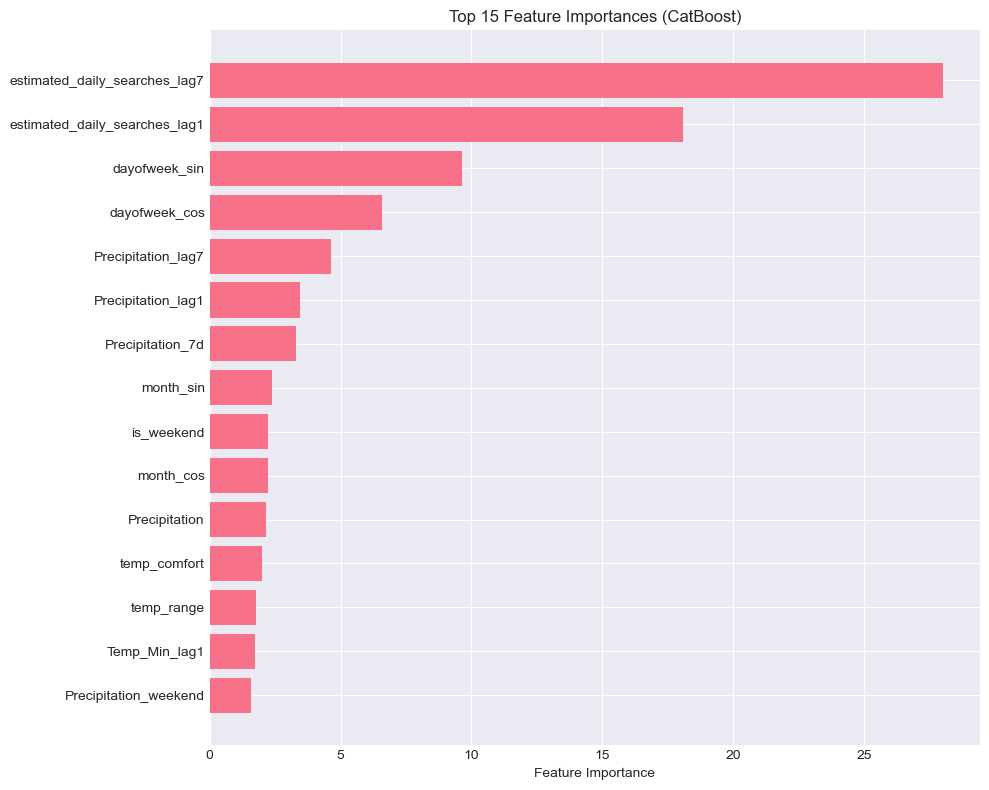

In [152]:
# CatBoost - Gradient boosting that handles categorical features natively
# Better at capturing non-linear relationships than linear models
print("=" * 60)
print("CatBoost Regression")
print("=" * 60)

# Identify categorical features (binary features can be treated as categorical)
categorical_features = ['is_weekend', 'is_holiday', 'precip_binary', 'precip_heavy']

# Filter to only include features that exist in our feature set
cat_features_indices = [i for i, col in enumerate(X_train.columns) if col in categorical_features]

print(f"Categorical features for CatBoost: {[X_train.columns[i] for i in cat_features_indices]}")
print(f"Categorical feature indices: {cat_features_indices}")

# CatBoost model with early stopping and better hyperparameters
catboost = CatBoostRegressor(
    iterations=1000,  # More iterations
    learning_rate=0.05,  # Lower learning rate for better convergence
    depth=8,  # Slightly deeper trees
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=False,  # Set to True to see training progress
    cat_features=cat_features_indices if cat_features_indices else None,
    l2_leaf_reg=3,  # L2 regularization
    border_count=128  # More splits for better accuracy
)

# Fit with early stopping using a validation set
catboost.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    verbose=False
)

y_pred_catboost = catboost.predict(X_test)
predictions['CatBoost'] = y_pred_catboost
results['CatBoost'] = evaluate_model(y_test, y_pred_catboost, "CatBoost")

# Feature importance
catboost_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': catboost.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (CatBoost):")
print(catboost_importance.head(15))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features_cb = catboost_importance.head(15)
plt.barh(range(len(top_features_cb)), top_features_cb['importance'])
plt.yticks(range(len(top_features_cb)), top_features_cb['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (CatBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 7. SHAP Interpretation (Understanding CatBoost Predictions)


SHAP Interpretation for CatBoost

Computing SHAP values (this may take a minute)...
SHAP values computed for 100 samples

1. SHAP Summary Plot (Feature Importance & Impact)
   - Features sorted by importance (top to bottom)
   - Red = high feature value, Blue = low feature value
   - Right = increases prediction, Left = decreases prediction


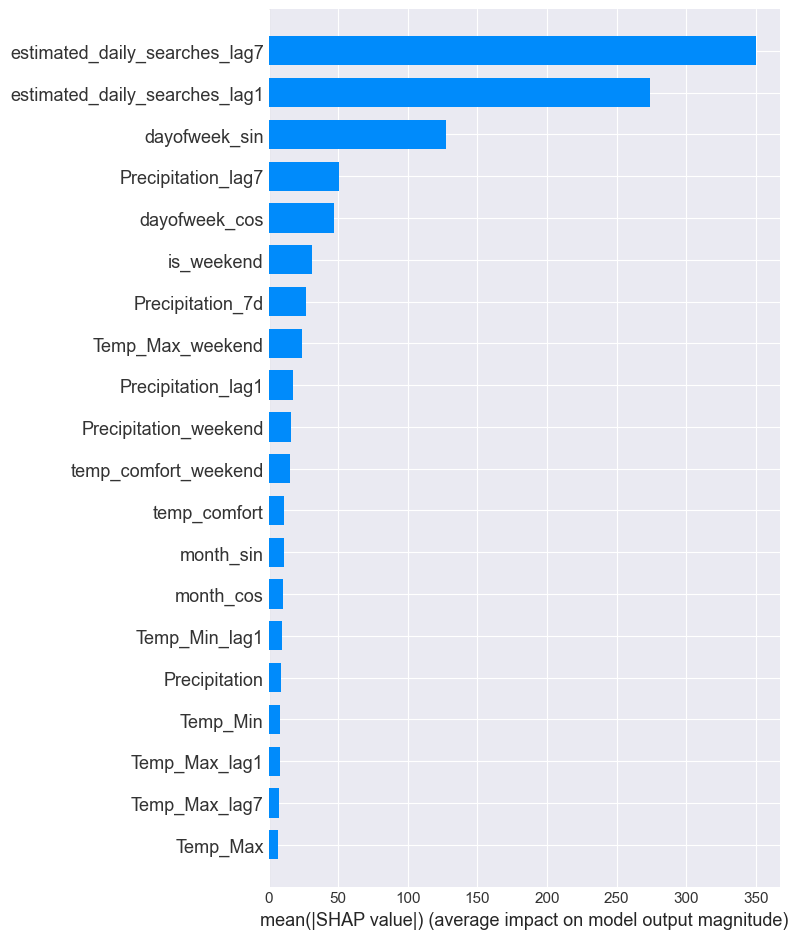


2. SHAP Detailed Summary Plot (Feature Impact Distribution)


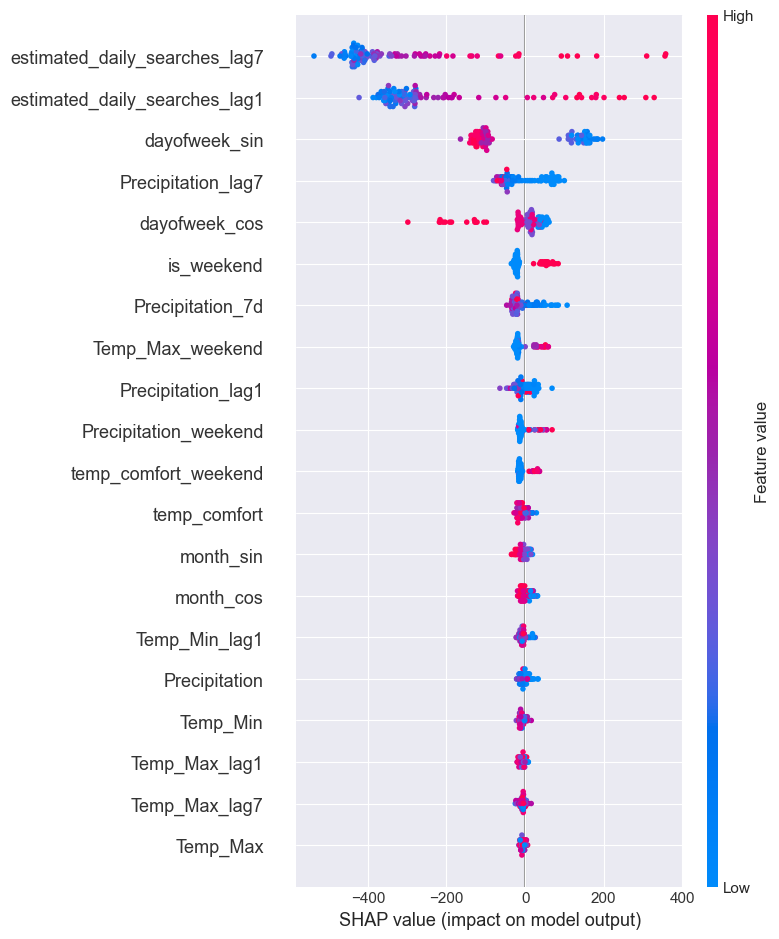


Top 15 Features by SHAP Importance:
                          feature  shap_importance
17  estimated_daily_searches_lag7       349.862622
16  estimated_daily_searches_lag1       273.681502
2                   dayofweek_sin       127.395419
20             Precipitation_lag7        50.671690
3                   dayofweek_cos        46.676743
0                      is_weekend        31.327072
22               Precipitation_7d        27.129038
24               Temp_Max_weekend        23.647761
15             Precipitation_lag1        17.275855
25          Precipitation_weekend        15.739640
26           temp_comfort_weekend        15.612755
10                   temp_comfort        11.387366
4                       month_sin        11.239819
5                       month_cos        10.398436
14                  Temp_Min_lag1         9.300125

3. SHAP Waterfall Plot (Example Prediction)
   Shows how each feature contributes to a single prediction


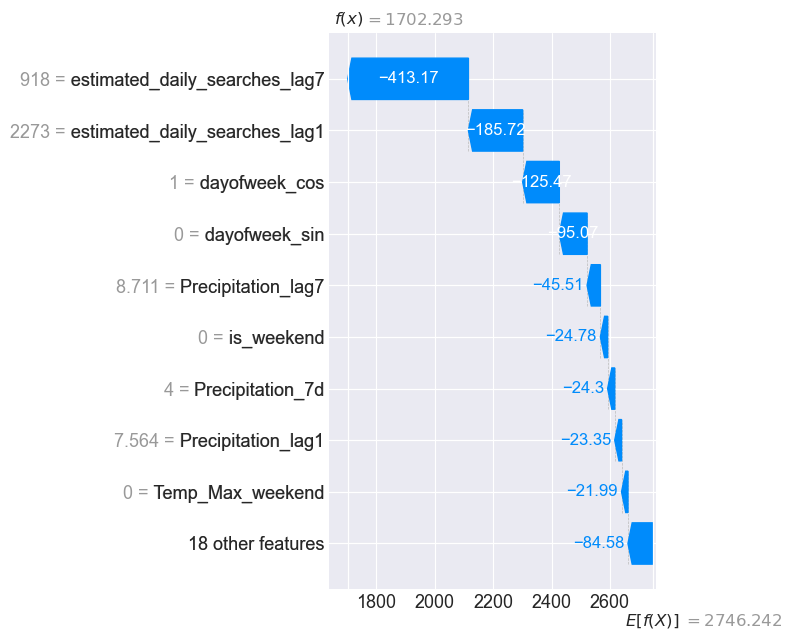


Example Prediction Details:
  Actual value: 1225
  Predicted value: 1702
  Base value (average): 2746
  Features contributing to this prediction:
    is_weekend                    :    -24.8
    dayofweek_sin                 :    -95.1
    dayofweek_cos                 :   -125.5
    month_sin                     :    +11.3
    Temp_Max                      :    -12.4
    temp_comfort                  :    -14.6
    Precipitation_lag1            :    -23.3
    estimated_daily_searches_lag1 :   -185.7
    estimated_daily_searches_lag7 :   -413.2
    Precipitation_lag7            :    -45.5
    Precipitation_7d              :    -24.3
    Temp_Max_weekend              :    -22.0
    Precipitation_weekend         :    -14.0
    temp_comfort_weekend          :    -16.5

SHAP Interpretation Complete


In [153]:
# SHAP (SHapley Additive exPlanations) - Explain CatBoost predictions
# SHAP provides interpretability for complex models by showing feature contributions
print("=" * 60)
print("SHAP Interpretation for CatBoost")
print("=" * 60)

# Create SHAP explainer (TreeExplainer is optimized for tree-based models)
# Use a sample of the training data for faster computation
print("\nComputing SHAP values (this may take a minute)...")
sample_size = min(100, len(X_train))  # Use 100 samples for faster computation
X_train_sample = X_train.iloc[:sample_size]

explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_train_sample)

print(f"SHAP values computed for {sample_size} samples")

# 1. Summary Plot - Shows feature importance and impact direction
print("\n1. SHAP Summary Plot (Feature Importance & Impact)")
print("   - Features sorted by importance (top to bottom)")
print("   - Red = high feature value, Blue = low feature value")
print("   - Right = increases prediction, Left = decreases prediction")
shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# 2. Detailed Summary Plot - Shows distribution of SHAP values
print("\n2. SHAP Detailed Summary Plot (Feature Impact Distribution)")
shap.summary_plot(shap_values, X_train_sample, show=False)
plt.tight_layout()
plt.show()

# 3. Feature Importance (from SHAP values - more accurate than model's built-in importance)
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'shap_importance': np.abs(shap_values).mean(0)
}).sort_values('shap_importance', ascending=False)

print("\nTop 15 Features by SHAP Importance:")
print(shap_importance.head(15))

# 4. Waterfall plot for a single prediction (example)
print("\n3. SHAP Waterfall Plot (Example Prediction)")
print("   Shows how each feature contributes to a single prediction")
sample_idx = 0  # First sample
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer.expected_value,
        data=X_train_sample.iloc[sample_idx].values,
        feature_names=X_train_sample.columns.tolist()
    ),
    show=False
)
plt.tight_layout()
plt.show()

# Show the actual prediction for this example
actual_pred = catboost.predict(X_train_sample.iloc[[sample_idx]])[0]
print(f"\nExample Prediction Details:")
print(f"  Actual value: {y_train.iloc[sample_idx]:.0f}")
print(f"  Predicted value: {actual_pred:.0f}")
print(f"  Base value (average): {explainer.expected_value:.0f}")
print(f"  Features contributing to this prediction:")
for i, (feature, value) in enumerate(zip(X_train_sample.columns, shap_values[sample_idx])):
    if abs(value) > 10:  # Only show significant contributions
        print(f"    {feature:30s}: {value:+8.1f}")

print("\n" + "=" * 60)
print("SHAP Interpretation Complete")
print("=" * 60)


## 7. Model Comparison


In [154]:
# Tree-based models removed for interpretability focus
# If needed, CatBoost is a good candidate for more complex modeling
pass


In [155]:
# Tree-based models (CatBoost, XGBoost, LightGBM) removed for interpretability focus
# If needed for more complex modeling, CatBoost is a good candidate
pass


## 7. Model Comparison



MODEL COMPARISON (sorted by RMSE)
                               RMSE         MAE       MAPE        R²
CatBoost                 684.555692  520.733373  19.287196  0.365175
Linear (Lasso-Selected)  689.829365  529.245131  19.853708  0.355356
Linear Regression        691.850447  532.135744  19.986908  0.351573
Ridge Regression         692.341429  532.883767  20.008200  0.350653
Lasso Regression         694.955199  535.161268  19.999766  0.345741
Baseline (Mean)          873.920732  673.163884  24.313002 -0.034619
Baseline (Median)        914.510612  689.368056  23.554200 -0.132958


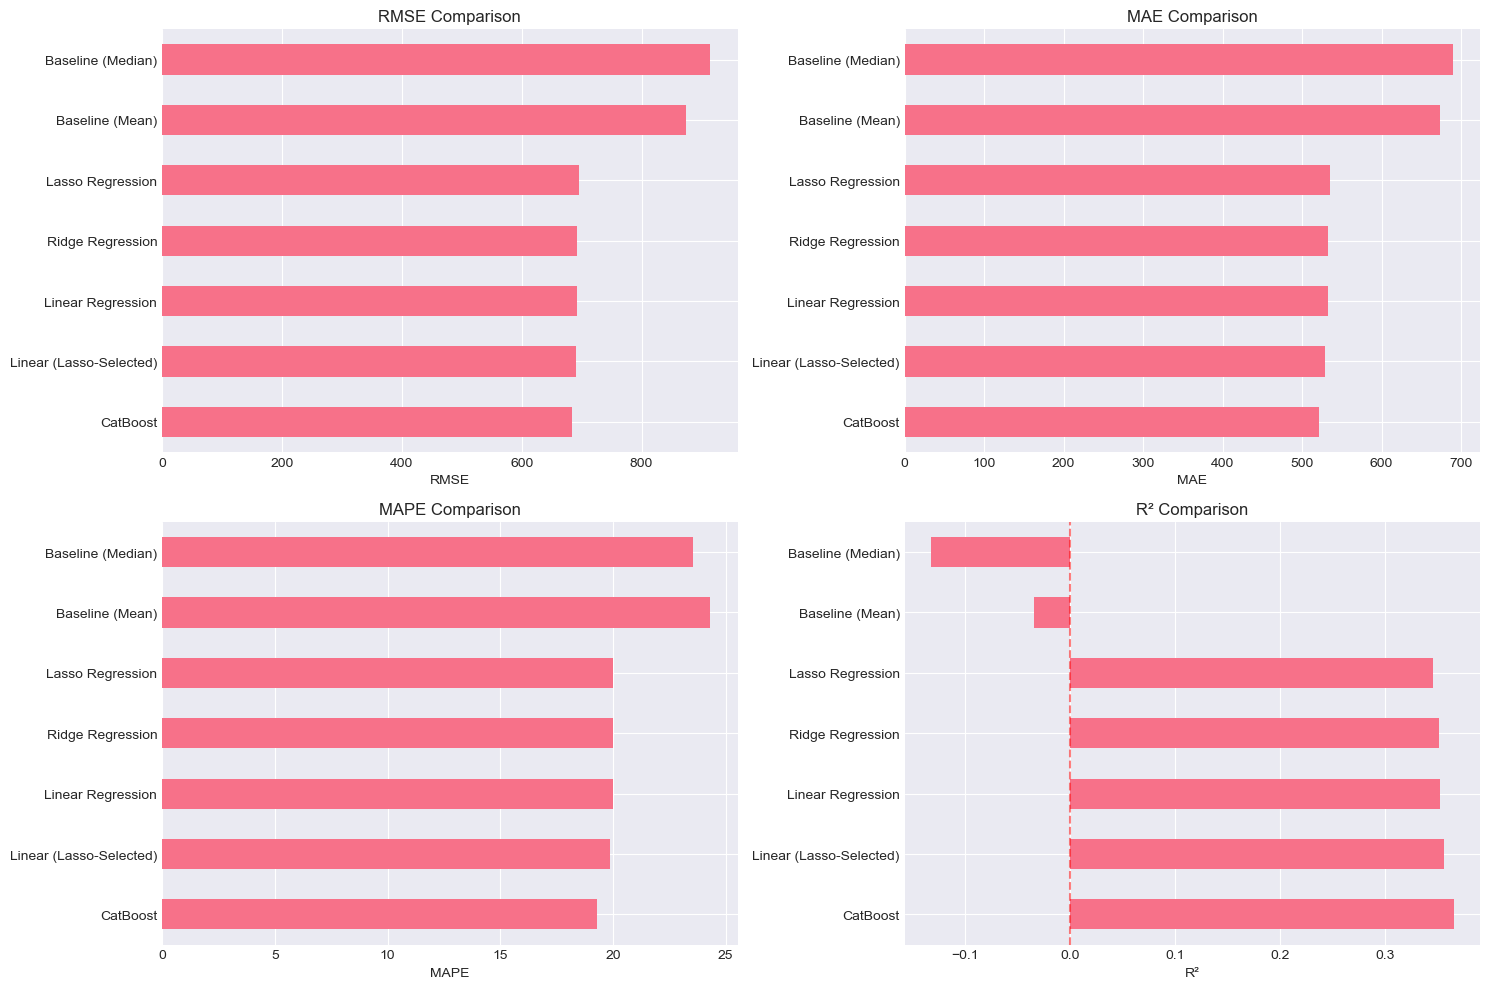

In [156]:
# Compare all models
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')

print("\n" + "=" * 60)
print("MODEL COMPARISON (sorted by RMSE)")
print("=" * 60)
print(results_df)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    results_df[metric].plot(kind='barh', ax=ax)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel(metric)
    if metric == 'R²':
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## 8. Predictions Visualization



Best Model: CatBoost


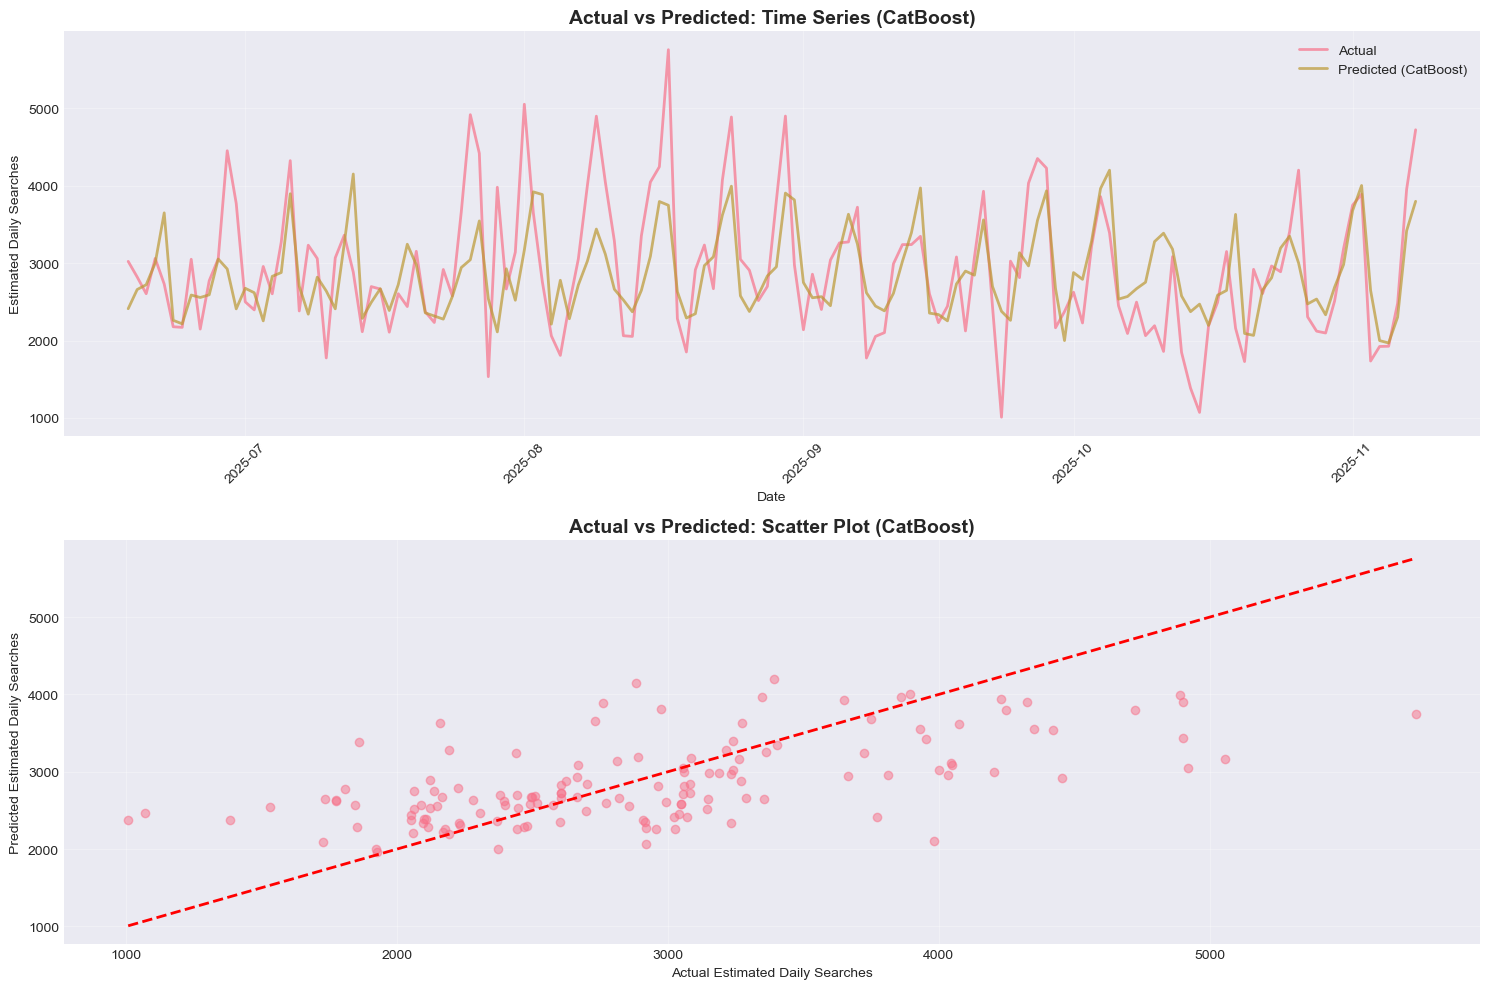

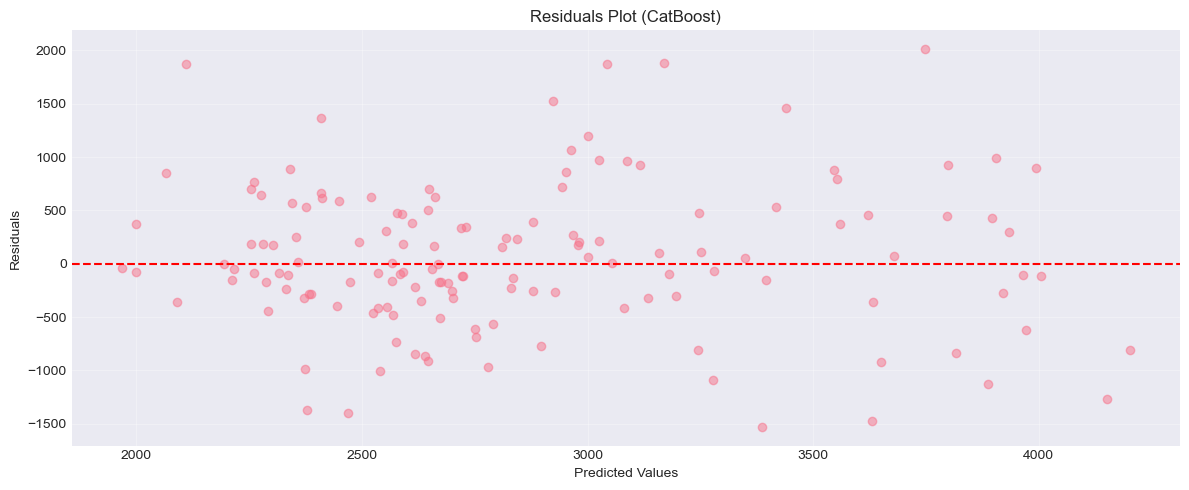

In [157]:
# Plot predictions vs actual for best model
best_model_name = results_df.index[0]
print(f"\nBest Model: {best_model_name}")

# Get predictions for best model
y_pred_best = predictions[best_model_name]

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Time series plot
axes[0].plot(test_df['Day'], y_test.values, label='Actual', alpha=0.7, linewidth=2)
axes[0].plot(test_df['Day'], y_pred_best, label=f'Predicted ({best_model_name})', alpha=0.7, linewidth=2)
axes[0].set_title(f'Actual vs Predicted: Time Series ({best_model_name})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Estimated Daily Searches')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Scatter plot
axes[1].scatter(y_test, y_pred_best, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[1].set_title(f'Actual vs Predicted: Scatter Plot ({best_model_name})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Estimated Daily Searches')
axes[1].set_ylabel('Predicted Estimated Daily Searches')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred_best
plt.figure(figsize=(12, 5))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot ({best_model_name})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
